In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

In [47]:
#get noise data
df1 = pd.read_csv("E:\MDA 2023\Full noise data\Jan\csv_results_42_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df2 = pd.read_csv("E:\MDA 2023\Full noise data\Feb\csv_results_42_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df3 = pd.concat([df1,df2], axis=0)
df3 = df3[['result_timestamp','laeq']]

In [10]:
# Convert noise datetime column to a Pandas datetime object
df3['result_timestamp'] = pd.to_datetime(df3['result_timestamp'], dayfirst=True)
df5 = df3

In [111]:
#df3 = df5

,laeq
result_timestamp,
2022-01-01 00:00:00.419,70.2
2022-01-01 00:00:01.419,69.9
2022-01-01 00:00:02.419,70.1
2022-01-01 00:00:03.419,64.9
2022-01-01 00:00:04.419,60.9
...,...
2022-02-28 23:59:54.631,45.1
2022-02-28 23:59:55.631,43.4
2022-02-28 23:59:56.631,45.8


In [53]:
# set timestamp column as the index
df3.set_index('result_timestamp', inplace=True)

In [112]:
# resample to one minute frequency and aggregate using the mean
df3 = df3.resample('10T').mean()

In [113]:
# Drop the datetime column from the index and reset the index to default
df3 = df3.reset_index()

In [114]:
# Extract minute-in-the-hour feature
df3['minute'] = df3['result_timestamp'].dt.minute.astype('int64')

# Extract hour-in-the-day feature
df3['hour'] = df3['result_timestamp'].dt.hour.astype('int64')

# Extract day-in-the-week feature
df3['weekday'] = df3['result_timestamp'].dt.dayofweek.astype('int64')

# Extract day-in-the-month feature
df3['day_of_month'] = df3['result_timestamp'].dt.day.astype('int64')

# Extract month-in-the-year feature
df3['month'] = df3['result_timestamp'].dt.month.astype('int64')

In [115]:
#create numeric indexes to merge on
df3['result_timestamp'] = df3['result_timestamp'].astype('int64')
df3.set_index('result_timestamp', inplace=True)
df3

,laeq,minute,hour,weekday,day_of_month,month
result_timestamp,,,,,,
1640995200000000000,54.790667,0,0,5,1,1
1640995800000000000,48.605833,10,0,5,1,1
1640996400000000000,54.277833,20,0,5,1,1
1640997000000000000,50.025333,30,0,5,1,1
1640997600000000000,48.907333,40,0,5,1,1
...,...,...,...,...,...,...
1646089800000000000,49.818500,10,23,0,28,2
1646090400000000000,50.440000,20,23,0,28,2
1646091000000000000,48.197000,30,23,0,28,2


In [116]:
#get weather data
df4 = pd.read_csv("E:\MDA 2023\dataverse_files\LC_2022Q1.csv")
df4 = df4[['DATEUTC', 'ID', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ', 'LC_DAILYRAIN','LC_WINDDIR',
          'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0']]
df4 = df4[df4['ID'] == 'LC-117']
df4['result_timestamp'] = df4['DATEUTC']
df4 = df4.drop(['DATEUTC','ID'], axis=1)
df4['result_timestamp'] = pd.to_datetime(df4['result_timestamp'])
df4['result_timestamp'] = df4['result_timestamp'].astype('int64')
df4.set_index('result_timestamp', inplace=True)
df4

,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
result_timestamp,,,,,,,,,,
1640995800000000000,87.0,11.29,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
1640996400000000000,87.0,11.22,37.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
1640997000000000000,87.0,11.22,38.0,0.0,0.0,0.0,43.0,0.04,0.0,13.28
1640997600000000000,87.0,11.22,37.0,0.0,0.0,0.0,23.0,0.01,0.0,13.28
1640998200000000000,87.0,11.22,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...
1648768800000000000,82.0,0.98,9.0,0.0,0.0,0.0,0.0,0.00,0.0,3.74
1648769400000000000,83.0,1.04,8.0,0.0,0.0,0.0,0.0,0.00,0.0,3.65
1648770000000000000,83.0,0.94,8.0,0.0,0.0,0.0,0.0,0.00,0.0,3.56


In [169]:
#merge noise and weather data
df = pd.merge(df3,df4,on='result_timestamp',validate="1:1")

In [170]:
df = df.reset_index()
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'])
df

,result_timestamp,laeq,minute,hour,weekday,day_of_month,month,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
0,2022-01-01 00:10:00,48.605833,10,0,5,1,1,87.0,11.29,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
1,2022-01-01 00:20:00,54.277833,20,0,5,1,1,87.0,11.22,37.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
2,2022-01-01 00:30:00,50.025333,30,0,5,1,1,87.0,11.22,38.0,0.0,0.0,0.0,43.0,0.04,0.0,13.28
3,2022-01-01 00:40:00,48.907333,40,0,5,1,1,87.0,11.22,37.0,0.0,0.0,0.0,23.0,0.01,0.0,13.28
4,2022-01-01 00:50:00,47.905000,50,0,5,1,1,87.0,11.22,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,2022-02-28 23:10:00,49.818500,10,23,0,28,2,76.0,-1.00,32.0,0.0,0.0,0.0,0.0,0.00,0.0,2.82
8491,2022-02-28 23:20:00,50.440000,20,23,0,28,2,75.0,-1.15,32.0,0.0,0.0,0.0,0.0,0.00,0.0,2.76
8492,2022-02-28 23:30:00,48.197000,30,23,0,28,2,76.0,-1.11,31.0,0.0,0.0,0.0,0.0,0.00,0.0,2.66
8493,2022-02-28 23:40:00,46.557333,40,23,0,28,2,77.0,-1.13,32.0,0.0,0.0,0.0,0.0,0.00,0.0,2.48


In [171]:
#inspect missing values for weather data
print(df.isnull()[df.isnull()['laeq']==True])

      result_timestamp  laeq  minute   hour  weekday  day_of_month  month  \
3600             False  True   False  False    False         False  False   
3601             False  True   False  False    False         False  False   
3602             False  True   False  False    False         False  False   
3603             False  True   False  False    False         False  False   
3604             False  True   False  False    False         False  False   
...                ...   ...     ...    ...      ...           ...    ...   
3673             False  True   False  False    False         False  False   
3674             False  True   False  False    False         False  False   
3675             False  True   False  False    False         False  False   
3676             False  True   False  False    False         False  False   
3677             False  True   False  False    False         False  False   

      LC_HUMIDITY  LC_DWPTEMP   LC_n  LC_RAD  LC_RAININ  LC_DAILYRAIN  \
36

In [172]:
#select only february, since missings are located in january
df = df[df['month']==2]

In [173]:
#doublecheck whether missings are gone
print(df.isnull()[df.isnull()['laeq']==True])

Empty DataFrame
Columns: [result_timestamp, laeq, minute, hour, weekday, day_of_month, month, LC_HUMIDITY, LC_DWPTEMP, LC_n, LC_RAD, LC_RAININ, LC_DAILYRAIN, LC_WINDDIR, LC_WINDSPEED, LC_RAD60, LC_TEMP_QCL0]
Index: []


In [174]:
# Drop the datetime column
df = df.drop('result_timestamp', axis=1)

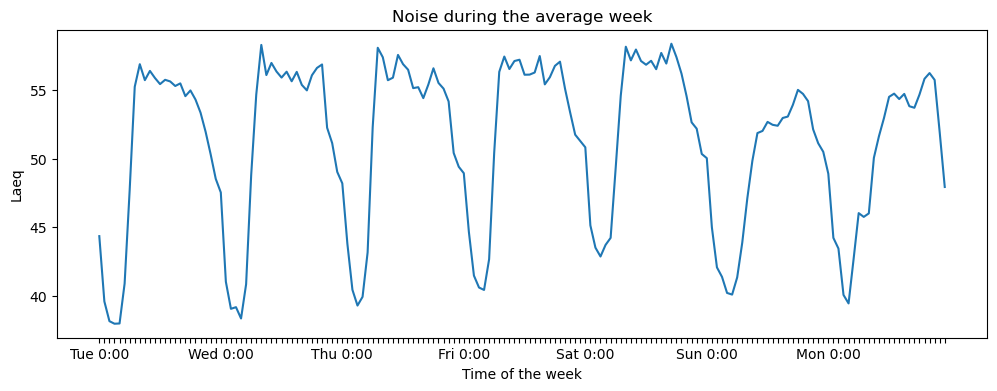

In [175]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_noise = df.groupby(["weekday", "hour"])["laeq"].mean()
average_week_noise.plot(ax=ax)
_ = ax.set(
    title="Noise during the average week",
    xticks=range(168),
    xticklabels=["Tue 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Wed 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Thu 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Fri 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Sat 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Sun 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Mon 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                ],
    xlabel="Time of the week",
    ylabel="Laeq",
)

fig.savefig("Noise_average_week_feb2.png")


In [176]:
#convert noise to relative noise (or relative crowdedness) as target (y), create dataframe with predictors only (X)
y = df["laeq"] / df["laeq"].max()
X = df.drop("laeq", axis="columns")

In [177]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=5000,
    test_size=500,
)

In [178]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,minute,hour,weekday,day_of_month,month,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
4463,0,0,1,1,2,83.0,1.13,36.0,0.0,0.0,0.0,58.0,0.19,0.0,3.72
4464,10,0,1,1,2,83.0,1.11,35.0,0.0,0.0,0.0,45.0,0.41,0.0,3.72
4465,20,0,1,1,2,83.0,1.19,36.0,0.0,0.0,0.0,45.0,0.19,0.0,3.76
4466,30,0,1,1,2,83.0,1.18,35.0,0.0,0.0,0.0,43.0,0.54,0.0,3.78
4467,40,0,1,1,2,82.0,1.04,35.0,0.0,0.0,0.0,44.0,0.39,0.0,3.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5942,30,6,4,11,2,82.0,1.82,35.0,0.0,0.0,0.0,56.0,0.53,0.0,4.70
5943,40,6,4,11,2,83.0,2.10,36.0,0.0,0.0,0.0,41.0,0.38,0.0,4.72
5944,50,6,4,11,2,82.0,1.95,35.0,0.0,0.0,0.0,38.0,0.91,0.0,4.72
5945,0,7,4,11,2,83.0,2.04,36.0,0.0,0.0,0.0,46.0,0.17,0.0,4.72


In [179]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,minute,hour,weekday,day_of_month,month,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
4463,0,0,1,1,2,83.0,1.13,36.0,0.0,0.0,0.0,58.0,0.19,0.0,3.72
4464,10,0,1,1,2,83.0,1.11,35.0,0.0,0.0,0.0,45.0,0.41,0.0,3.72
4465,20,0,1,1,2,83.0,1.19,36.0,0.0,0.0,0.0,45.0,0.19,0.0,3.76
4466,30,0,1,1,2,83.0,1.18,35.0,0.0,0.0,0.0,43.0,0.54,0.0,3.78
4467,40,0,1,1,2,82.0,1.04,35.0,0.0,0.0,0.0,44.0,0.39,0.0,3.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7942,50,3,4,25,2,76.0,-0.33,31.0,0.0,0.0,0.0,35.0,0.03,0.0,3.38
7943,0,4,4,25,2,77.0,-0.36,32.0,0.0,0.0,0.0,0.0,0.00,0.0,3.23
7944,10,4,4,25,2,78.0,-0.46,32.0,0.0,0.0,0.0,0.0,0.00,0.0,3.04
7945,20,4,4,25,2,78.0,-0.61,31.0,0.0,0.0,0.0,41.0,0.07,0.0,2.90


In [180]:
#run histogram gradient boosting model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = make_pipeline(HistGradientBoostingRegressor()).set_output(transform="pandas")

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.051 +/- 0.007
Root Mean Squared Error: 0.072 +/- 0.010


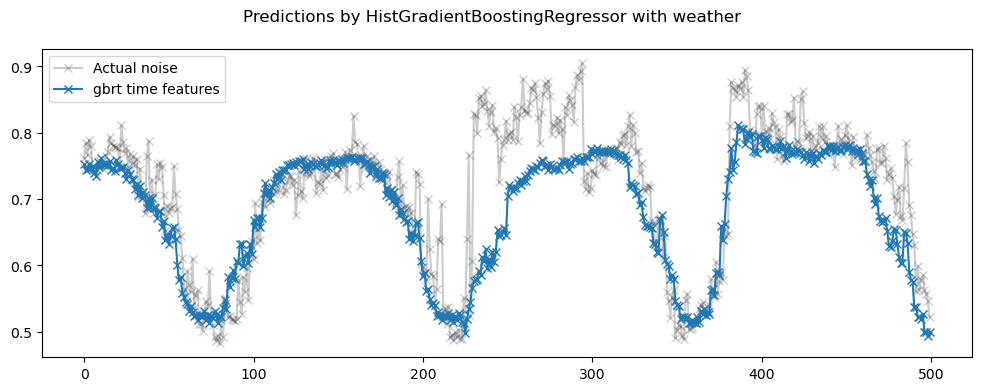

In [181]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


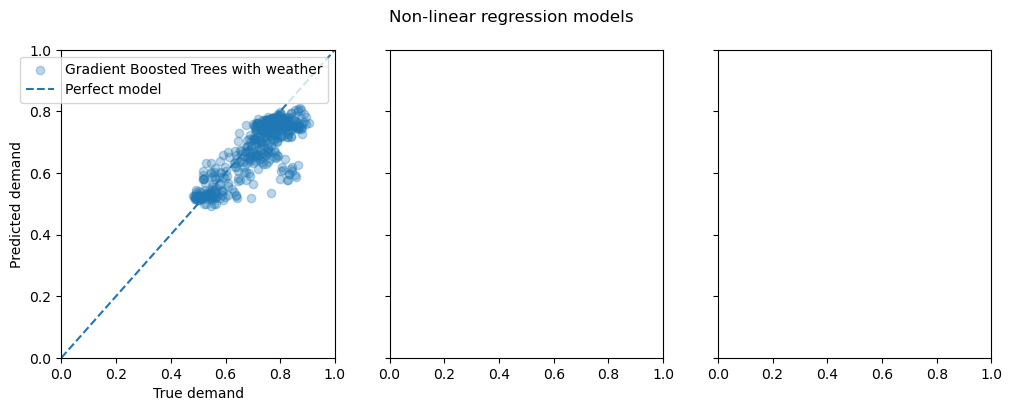

In [182]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 1], [0, 1], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

In [183]:
#delete weather columns to compare models
df = df[['laeq','minute','hour','weekday','day_of_month','month']]

In [184]:
#convert noise to relative noise (or relative crowdedness) as target (y), create dataframe with predictors only (X)
y = df["laeq"] / df["laeq"].max()
X = df.drop("laeq", axis="columns")

In [185]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=5000,
    test_size=500,
)

In [186]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,minute,hour,weekday,day_of_month,month
4463,0,0,1,1,2
4464,10,0,1,1,2
4465,20,0,1,1,2
4466,30,0,1,1,2
4467,40,0,1,1,2
...,...,...,...,...,...
5942,30,6,4,11,2
5943,40,6,4,11,2
5944,50,6,4,11,2
5945,0,7,4,11,2


In [187]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,minute,hour,weekday,day_of_month,month
4463,0,0,1,1,2
4464,10,0,1,1,2
4465,20,0,1,1,2
4466,30,0,1,1,2
4467,40,0,1,1,2
...,...,...,...,...,...
7942,50,3,4,25,2
7943,0,4,4,25,2
7944,10,4,4,25,2
7945,20,4,4,25,2


In [188]:
#run histogram gradient boosting model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = make_pipeline(HistGradientBoostingRegressor()).set_output(transform="pandas")

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.047 +/- 0.008
Root Mean Squared Error: 0.064 +/- 0.010


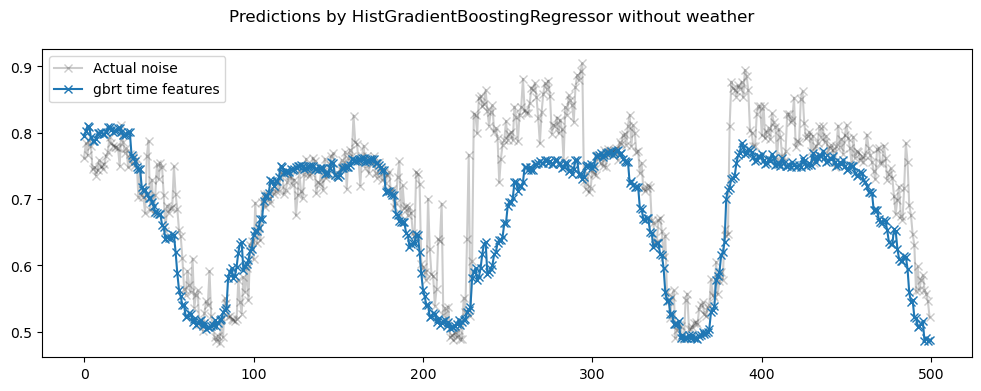

In [189]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor without weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


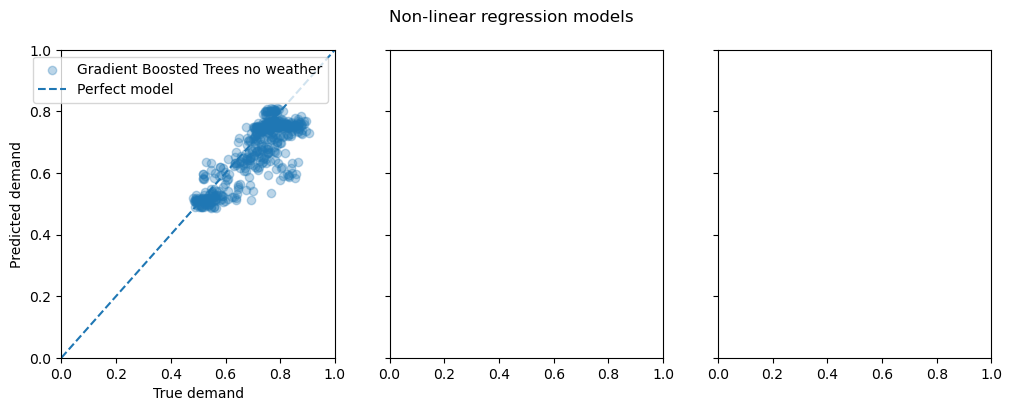

In [190]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees no weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 1], [0, 1], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()